# Setting up the model and the parameters

In [1]:
import ihor
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
from tqdm import tqdm

# load the model
model = ihor.vdj.Model.load_model("../models/human_T_beta/model_params.txt",
"../models/human_T_beta/model_marginals.txt",
"../models/human_T_beta/V_gene_CDR3_anchors.csv",
"../models/human_T_beta/J_gene_CDR3_anchors.csv")


# define parameters for the alignment and the inference
align_params = ihor.AlignmentParameters()
infer_params = ihor.InferenceParameters()

# Default parameters favour accuracy rather than speed
# generally no need to modify them
print(align_params)
print(infer_params)

AlignmentParameters(min_score_v=0, min_score_j=0, max_error_d=100. left_v_cutoff=40)
InferenceParameters(min_likelihood=0, min_ratio_likelihood=0, infer=false. store_best_event=true)


## Evaluating a given sequence

In [2]:
sequence = "GATGCTGAAATCACCCAGAGCCCAAGACACAAGATCACAGAGACAGGAAGGCAGGTGACCTTGGCGTGTCACCAGACTTGGAACCACAACAATATGTTCTGGTATCGACAAGACCTGGGACATGGGCTGAGGCTGATCCATTACTCATATGGTGTTCACGACACTAACAAAGGAGAAGTCTCAGATGGCTACAGTGTCTCTAGATCAAACACAGAGGACCTCCCCCTCACTCTGGAGTCTGCTGCCTCCTCCCAGACATCTGTATATTTCTGCGCCAGCAGTGAGCGGACAGGGGGCCTAGCAATCAGCCCCAGCATTTTGGTGATGGGACTCGACTCTCCATCCTAG"

# first align the sequence
alignment = model.align_sequence(sequence, align_params)

# then evaluate the alignment
result = model.evaluate(alignment, infer_params)

# Clean display of the result
print(result.display(model))

Result:
	Likelihood: 3.24e-13, pgen: 0.00e0
	Most likely event:
	- CDR3 (nucleotides): TGCGCCAGCAGTGAGCGGACAGGGGGCCTAGCAATCAGCCCCAGCATTTT 
	- CDR3 (amino acids):  
	- V name: TRBV10-1*02 
	- J name: TRBJ1-5*01 
	- likelihood ratio: 0.08366745966613477 
 


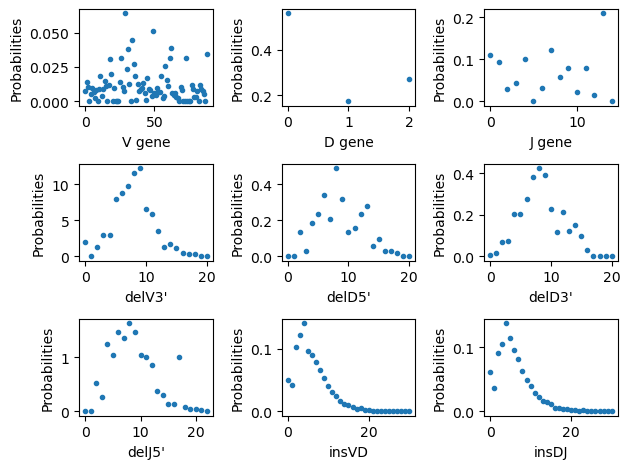

array([1.94021318e+00, 5.67251817e-02, 1.29175147e+00, 2.93673213e+00,
       3.03304651e+00, 7.93925112e+00, 8.80454796e+00, 9.71969439e+00,
       1.16137818e+01, 1.22176280e+01, 6.61989570e+00, 5.95615318e+00,
       3.56701897e+00, 1.32475837e+00, 1.76946331e+00, 1.10985637e+00,
       4.64892714e-01, 2.89894173e-01, 2.99503754e-01, 1.17364929e-02,
       3.34552121e-02])

In [3]:
## Representation of the probabilities of the events for that specific sequence
fig, axes = plt.subplots(3, 3)

for ax in axes.flatten():
    ax.set_ylabel("Probabilities")

# Marginal probabilities of the V genes (for this specific sequence)
pv = result.features.vdj.probas.sum(axis=(1,2))
axes[0, 0].plot(pv, '.')
axes[0, 0].set_xlabel("V gene")

# Marginal probabilities of the D genes
pd = result.features.vdj.probas.sum(axis=(0,2))
axes[0, 1].plot(pd, '.')
axes[0, 1].set_xlabel("D gene")

# Marginal probabilities of the J genes
pj = result.features.vdj.probas.sum(axis=(0,1))
axes[0, 2].plot(pj, '.')
axes[0, 2].set_xlabel("J gene")

# Marginal probabilities of the V deletion 
pdelv = result.features.delv.probas.sum(axis=(1))
axes[1, 0].plot(pdelv, '.')
axes[1, 0].set_xlabel("delV3'")

# Marginal probabilities of the D5 deletion 
pdeld5 = result.features.deld.probas.sum(axis=(1,2))
axes[1, 1].plot(pdeld5, '.')
axes[1, 1].set_xlabel("delD5'")

# Marginal probabilities of the D3 deletion 
pdeld3 = result.features.deld.probas.sum(axis=(0,2))
axes[1, 2].plot(pdeld3, '.')
axes[1, 2].set_xlabel("delD3'")

# Marginal probabilities of the J deletion 
pdelj = result.features.delj.probas.sum(axis=(1))
axes[2, 0].plot(pdelj, '.')
axes[2, 0].set_xlabel("delJ5'")
# Marginal probabilities of the insvd insertions
pinsvd = result.features.insvd.length_distribution
axes[2, 1].plot(pinsvd, '.')
axes[2, 1].set_xlabel("insVD")
# Marginal probabilities of the insdj insertions
pinsdj = result.features.insdj.length_distribution
axes[2, 2].plot(pinsdj, '.')
axes[2, 2].set_xlabel("insDJ")

plt.tight_layout()
plt.show()

# Marginal probabilities of the deletion on V, 3'
result.features.delv.probas.sum(axis=1)

## Generating sequences

In [4]:
seed = 42
# or model.generator() if you don't want a seed
generator = model.generator(seed) 
print(generator.generate(True).full_seq)

GAAGCTGACATCTACCAGACCCCAAGATACCTTGCTATAGGGACAGGAAAGAAGATCACTCTGGAATGTTCTCTAACCATGGGCCATGAGAAAATGTACTGGTATCAACAAGATCCAGGAATGGAACTACACCTCATCCACTATTCCTATGGAGTTAATTCCACAGAGAAGGGAGATCTTTCCTCTGAGTCAACAGTCTCCAGAATAAGGACGGAGCATTTTCCCCTGACCCTGGAGTCTGCCAGGCCCTCACATACCTCTCAGTACCTCTGTGCCAGCAGTGAGGACAGGAACTCCACTGAAGCTTTCTTTGGACAAGGCACCAGACTCTCAGTTGTAG


## Inferring a model

In [5]:
# create an uniform model with the same V/D/J genes & range for deletions
uniform_model = model.uniform()

In [6]:
# we're going to re-infer the model starting from the uniform_model

seed = 42
print("Generate...")
generator = model.generator(seed)
sequences = [generator.generate(True).full_seq
             for a in tqdm(range(1000))]

print("Align...")
# first align the sequences
alignments = [uniform_model.align_sequence(s, align_params) 
              for s in tqdm(sequences)]




Generate...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 168927.62it/s]


Align...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:23<00:00, 41.93it/s]


In [7]:
print("Infer...")
models = {}
for rd in range(10):
    print(rd, end=" ")
    models[rd] = uniform_model.copy()
    uniform_model.infer(alignments, infer_params)


Infer...
0 1 2 3 4 5 6 7 8 9 